In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn')

In [2]:
fake_df = pd.read_csv('Fake.csv')
real_df = pd.read_csv('True.csv')

In [3]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
fake_df = fake_df[['title', 'text']]
real_df = real_df[['title', 'text']]

fake_df['class'] = 1
real_df['class'] = 0

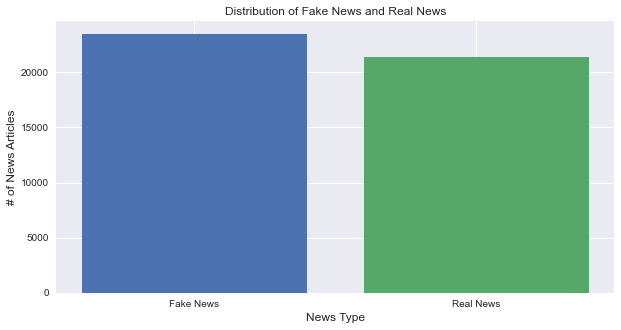

In [5]:
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df))
plt.bar('Real News', len(real_df))
plt.title('Distribution of Fake News and Real News', size=12)
plt.xlabel('News Type', size=12)
plt.ylabel('# of News Articles', size=12);

In [6]:
df = pd.concat([fake_df, real_df], ignore_index=True, sort=False)
df.head()

,title,text,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,1


In [7]:
df['title_text'] = df['title'] + ' ' + df['text']
df.drop(['title', 'text'], axis=1, inplace=True)
df.head()

,class,title_text
0,1,Donald Trump Sends Out Embarrassing New Year’...
1,1,Drunk Bragging Trump Staffer Started Russian ...
2,1,Sheriff David Clarke Becomes An Internet Joke...
3,1,Trump Is So Obsessed He Even Has Obama’s Name...
4,1,Pope Francis Just Called Out Donald Trump Dur...


# Model Testing

In [20]:
import re
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [21]:
df_log = df.copy()

In [22]:
def preprocessor(text):

    text = re.sub('<[^>]*>', '', text)
    text = re.sub(r'[^\w\s]','', text)
    text = text.lower()

    return text

df_log['title_text'] = df_log['title_text'].apply(preprocessor)

In [23]:
porter = PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [24]:
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None,
                        tokenizer=tokenizer_porter,
                        use_idf=True,
                        norm='l2',
                        smooth_idf=True)

X = tfidf.fit_transform(df_log['title_text'])
y = df_log['class'].values

## Build a classification model using various methods

In [25]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [26]:
model_params = {

    'logistic_regression' : {
        'model': LogisticRegression(multi_class='auto'),
        'params': {
            'C': [1,5,10],
            'solver':['newton-cg', 'liblinear']
        }
    },

    'kneighbours': {
        'model': KNeighborsClassifier(n_jobs=-1),
        "params": {
            
            'n_neighbors' : [5, 10 , 100],
        }
    },

}

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5)
scores = []

for model_name, mp in model_params.items():
    print(model_name)
    clf =  GridSearchCV(mp['model'], mp['params'], cv=cv, return_train_score=False)
    clf.fit(X, y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_.round(4),
        'best_params': clf.best_params_
    })

logistic_regression
kneighbours


In [28]:
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df.sort_values('best_score', ascending=False)

,model,best_score,best_params
0,logistic_regression,0.9905,"{'C': 10, 'solver': 'newton-cg'}"
1,kneighbours,0.8309,{'n_neighbors': 100}


## Using the best model 

In [11]:
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)

In [30]:
model = LogisticRegression(multi_class='auto', C=10, solver='newton-cg')
model.fit(X_train, y_train)

LogisticRegression(C=10, solver='newton-cg')

In [31]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
y_pred = model.predict(X_test)
print("---Test Set Results---")
print("Accuracy with logreg: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

---Test Set Results---
Accuracy with logreg: 0.9944320712694877
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4284
           1       1.00      0.99      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



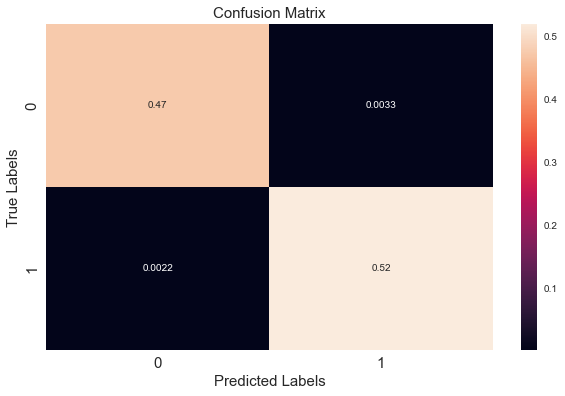

In [36]:
import seaborn as sns


matrix = confusion_matrix(y_pred, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15);

# Keras

In [8]:
import tensorflow as tf

In [9]:
X = df['title_text']
y = df['class']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

In [13]:
import re

def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

In [14]:
vocab_size = 10000
embedding_dim = 64
max_length = 256
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

tokenizer.fit_on_texts(X_train)

In [16]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [17]:
len(X_train[0])

356

In [18]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding=padding_type, truncating=trunc_type, maxlen=max_length)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding=padding_type, truncating=trunc_type, maxlen=max_length)

In [19]:
len(X_train[0])

256

In [20]:
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [31]:
input_dim = X_train.shape[1]

## Dense

In [40]:
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
tf.keras.layers.GlobalMaxPool1D(),
tf.keras.layers.Dense(128, input_dim=input_dim, activation='relu'),
tf.keras.layers.Dropout(0.25, name="dropout"),
tf.keras.layers.Dense(64, input_dim=input_dim, activation='relu'),

tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 256, 64)           640000    
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                      

In [41]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=METRICS)

In [42]:
history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10


C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1011/1011 [==============================] - 10s 9ms/step - loss: 0.3669 - accuracy: 0.8556 - precision: 0.7901 - recall: 0.9863 - val_loss: 0.0339 - val_accuracy: 0.9935 - val_precision: 0.9960 - val_recall: 0.9914
Epoch 2/10
1011/1011 [==============================] - 9s 9ms/step - loss: 0.0212 - accuracy: 0.9954 - precision: 0.9972 - recall: 0.9941 - val_loss: 0.0213 - val_accuracy: 0.9944 - val_precision: 0.9971 - val_recall: 0.9919
Epoch 3/10
1011/1011 [==============================] - 9s 9ms/step - loss: 0.0147 - accuracy: 0.9959 - precision: 0.9975 - recall: 0.9946 - val_loss: 0.0193 - val_accuracy: 0.9947 - val_precision: 0.9977 - val_recall: 0.9919
Epoch 4/10
1011/1011 [==============================] - 9s 9ms/step - loss: 0.0114 - accuracy: 0.9966 - precision: 0.9980 - recall: 0.9955 - val_loss: 0.0185 - val_accuracy: 0.9947 - val_precision: 0.9977 - val_recall: 0.9919
Epoch 5/10
1011/1011 [==============================] - 9s 9ms/step - loss: 0.0087 - accuracy: 0.9974 - pr

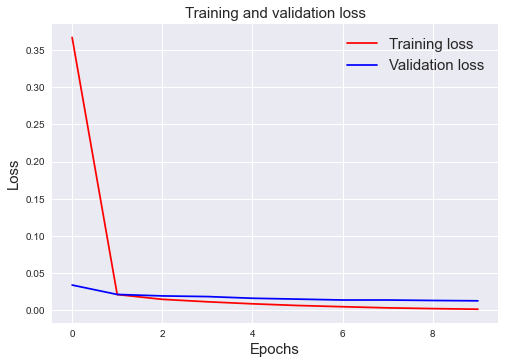

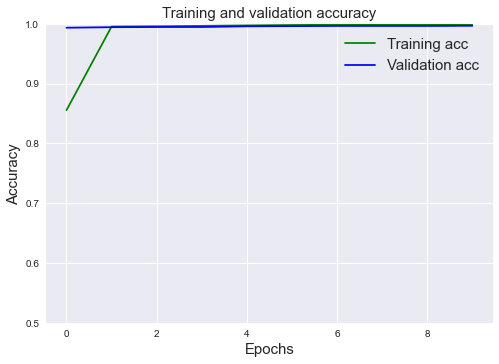

In [43]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

# plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss', size=15)
plt.legend(prop={'size': 15})
plt.show()

# plt.figure(figsize=(10,6))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Accuracy', size=15)
plt.legend(prop={'size': 15})
plt.ylim((0.5,1))
plt.show()

In [44]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

print("---Test Set Results---")
print("Accuracy: {}".format(accuracy_score(y_test, binary_predictions)))
print(classification_report(y_test, binary_predictions))

---Test Set Results---
Accuracy: 0.9971492204899778
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5354
         1.0       1.00      1.00      1.00      5871

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



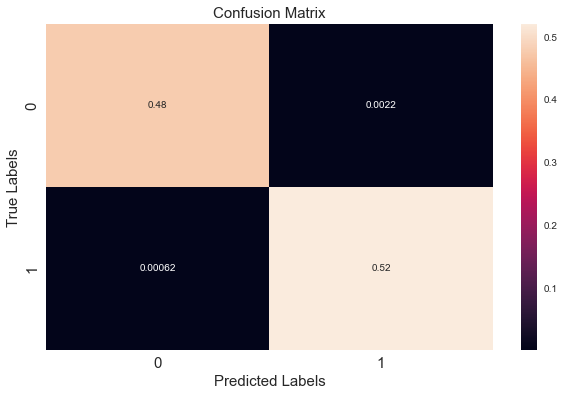

In [45]:
import seaborn as sns


matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15);

## LSTM

In [21]:
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True)),
tf.keras.layers.Dropout(0.1, name="dropout"),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 64)           640000    
                                                                 
 bidirectional (Bidirectiona  (None, 256, 128)         66048     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256, 128)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 747,329
Trainable params: 747,329
Non-trai

In [22]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=METRICS)

In [23]:
history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10


C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1011/1011 [==============================] - 235s 227ms/step - loss: 0.1538 - accuracy: 0.9247 - precision: 0.9018 - recall: 0.9609 - val_loss: 0.0138 - val_accuracy: 0.9976 - val_precision: 0.9960 - val_recall: 0.9994
Epoch 2/10
1011/1011 [==============================] - 239s 236ms/step - loss: 0.0177 - accuracy: 0.9968 - precision: 0.9965 - recall: 0.9973 - val_loss: 0.0109 - val_accuracy: 0.9979 - val_precision: 0.9966 - val_recall: 0.9994
Epoch 3/10
1011/1011 [==============================] - 240s 237ms/step - loss: 0.0037 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - val_loss: 0.0086 - val_accuracy: 0.9979 - val_precision: 0.9971 - val_recall: 0.9988
Epoch 4/10
1011/1011 [==============================] - 241s 238ms/step - loss: 0.0018 - accuracy: 0.9998 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.0063 - val_accuracy: 0.9985 - val_precision: 0.9983 - val_recall: 0.9988
Epoch 5/10
1011/1011 [==============================] - 245s 242ms/step - loss: 0.0011 - ac

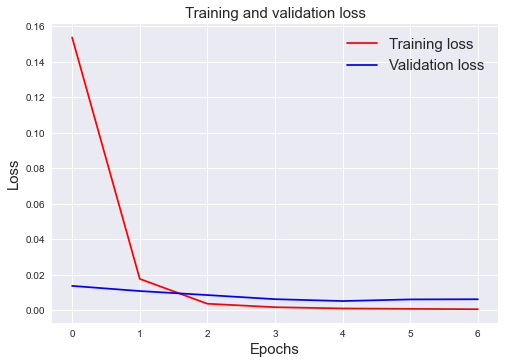

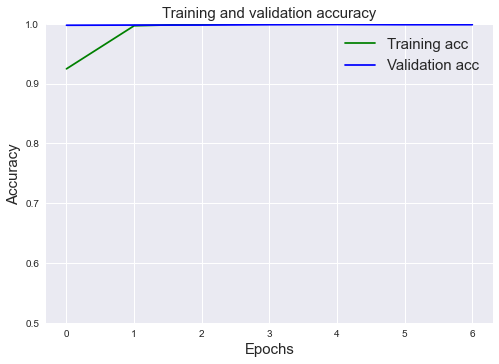

In [25]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

# plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss', size=15)
plt.legend(prop={'size': 15})
plt.show()

# plt.figure(figsize=(10,6))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Accuracy', size=15)
plt.legend(prop={'size': 15})
plt.ylim((0.5,1))
plt.show()

In [30]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

print("---Test Set Results---")
print("Accuracy: {}".format(accuracy_score(y_test, binary_predictions)))
print(classification_report(y_test, binary_predictions))

---Test Set Results---
Accuracy: 0.9977728285077951
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5354
         1.0       1.00      1.00      1.00      5871

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



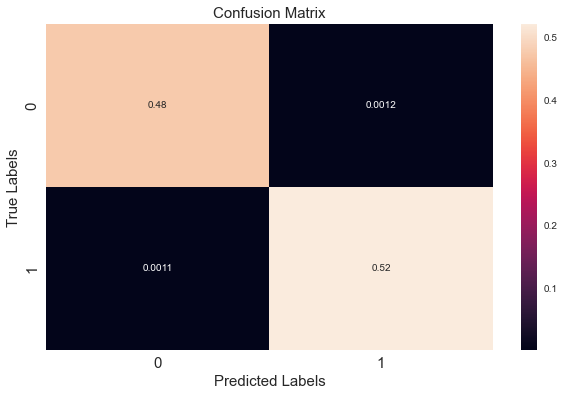

In [29]:
import seaborn as sns


matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15);